# Capstone project

---

Car accident model - based on Data from the UK Department for Transport (2005-2014)

Data files provide detailed road safety data about the circumstances of personal injury road accidents in GB from 2005 to 2014:

- Accident file: main data set contains information about accident severity, weather, location, date, hour, day of week, road type…
- Vehicle file: contains information about vehicle type, vehicle model, engine size, driver sex, driver age, car age…
- Casualty file: contains information about casualty severity, age, sex social class, casualty type, pedestrian or car passenger…

---

# Introduction

Unfortunately, car accidents happen.

Therefore we will try to answer the following question: would it be possible to understand/predict the severity of an eventual accident for a car driver if ever happening? We will use easy to have variables to develop the model so that anyone can use it before driving it’s car. 

Such a predictive model could be interesting for instance for:
- Insurance companies to set a final price for products based on customer/drivers characteristics.
- For government authorities to forecast casualties that may occur during a 	year based on vehicles registered and drivers records and plan measures to reduce those casualties numbers.
- To generate awareness in individuals so that they are aware of the need of replacing their car, be even more careful when it rains or when it's a foggy day, etc.

We will be exploring the feasibility of creating such a predictive model based on variables that could be stored into the following categories:

- Driver data: age, etc.
- Time, road and environmental conditions: visibility, weather conditions, moment of the year, etc.
- Car specifications: engine capacity, driver side, etc.
- Parameters of the accident: speed, point of impact, etc.

Based on those variables the model would predict if the driver ever has an accident if it's going to be "fatal" or "Serious/Slight" with a certain confidence (binary classification problem).

To proceed we will be using the database published on Kaggle.com called "UK Accidents 10 years history with many variables" that collects accidents that took place from 2005-2014 in UK roads. Data are stored in 3 tables: accidents, vehicles and casualties and can be found in the following link:

https://www.kaggle.com/benoit72/uk-accidents-10-years-history-with-many-variables

Important to note that this database is likely to give insights and a prediction model to be used only for countries like the United Kingdom, Japan, Australia, India (more than 50 countries) where traffic happens from the left side.

---

### 0. Loading data and packages

In [1]:
# Loading pkg needed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

!pip install scikit-learn
print('Scikit-learn lib Installed!')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.tree import plot_tree

Scikit-learn lib Installed!


In [2]:
# Loading data for each .csv data file available and dropping columns that wouldn't 
# look as adequate or specially relevant to build a model.

df_accidents = pd.read_csv('Accidents0514.csv')

atrib_to_drop_df_accidents = ['Location_Easting_OSGR','Location_Northing_OSGR','Longitude','Latitude',
                             'Police_Force','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities',
                             'Special_Conditions_at_Site','Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident','LSOA_of_Accident_Location',
                             '1st_Road_Class','1st_Road_Number','Junction_Detail','Junction_Control','2nd_Road_Class','2nd_Road_Number',
                             'Number_of_Vehicles','Local_Authority_(District)','Local_Authority_(Highway)','Road_Type','Number_of_Casualties',
                             'Weather_Conditions','Time']

df_accidents.drop(columns = atrib_to_drop_df_accidents, inplace=True)

df_vehicles = pd.read_csv('Vehicles0514.csv')

atrib_to_drop_df_vehicles = ['Towing_and_Articulation','Vehicle_Manoeuvre','Vehicle_Location-Restricted_Lane','Junction_Location',
                            'Skidding_and_Overturning','Hit_Object_in_Carriageway','Vehicle_Leaving_Carriageway','Hit_Object_off_Carriageway',
                            'Driver_IMD_Decile','Driver_Home_Area_Type','Was_Vehicle_Left_Hand_Drive?','Journey_Purpose_of_Driver',
                            'Propulsion_Code','Engine_Capacity_(CC)','Vehicle_Reference']

df_vehicles.drop(columns = atrib_to_drop_df_vehicles, inplace=True)

df_casualties = pd.read_csv('Casualties0514.csv')

atrib_to_drop_df_casualties = ['Casualty_Reference','Sex_of_Casualty','Age_of_Casualty','Age_Band_of_Casualty',
                               'Pedestrian_Location','Pedestrian_Movement','Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker',
                               'Casualty_Home_Area_Type','Car_Passenger','Casualty_Type','Vehicle_Reference']

df_casualties.drop(columns = atrib_to_drop_df_casualties, inplace=True)

C:\Users\Sergio\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1. Data wrangling

In [3]:
# We join dataframes based on key column Accident_Index
df = df_vehicles.join(df_casualties.set_index('Accident_Index'), on='Accident_Index')
df = df.join(df_accidents.set_index('Accident_Index'), on='Accident_Index')
print(df.shape)

(4287593, 16)


In [4]:
print(df.shape)
# According to the data 
df = df.replace(-1,np.NaN)
print(df.isna().sum())

(4287593, 16)
Accident_Index                   0
Vehicle_Type                   554
1st_Point_of_Impact           2418
Sex_of_Driver                   46
Age_of_Driver               405664
Age_Band_of_Driver          405664
Age_of_Vehicle             1155488
Casualty_Class                   0
Casualty_Severity                0
Accident_Severity                0
Date                             0
Day_of_Week                      0
Speed_limit                      0
Light_Conditions                 0
Road_Surface_Conditions       4824
Urban_or_Rural_Area              0
dtype: int64


In [5]:
df.drop(columns = ['Age_of_Driver','Age_Band_of_Driver','Age_of_Vehicle'], inplace = True)

In [6]:
print(df.isna().sum())
print(df.shape)

Accident_Index                0
Vehicle_Type                554
1st_Point_of_Impact        2418
Sex_of_Driver                46
Casualty_Class                0
Casualty_Severity             0
Accident_Severity             0
Date                          0
Day_of_Week                   0
Speed_limit                   0
Light_Conditions              0
Road_Surface_Conditions    4824
Urban_or_Rural_Area           0
dtype: int64
(4287593, 13)


In [7]:
# After joining the tables, Accident_Index can be drop now and we can drop rows with missing data
df.dropna(axis=0,inplace=True)
print('Shape after drop of rows contaning NaN values:', df.shape)

# After joining the tables, Accident_Index can be drop now
df.drop(columns = 'Accident_Index', inplace=True)
print('Shape after join of tables and drop of a priori no needed variables :', df.shape)

# In case some rows would be duplicated we remove them
df.drop_duplicates()
print('Shape after drop of duplicated: ', df.shape)

# We want to check at this point the distribution of the Accident_Severity in our dataset
print('Distribution of Accident_Severity after join tables: ',df['Accident_Severity'].value_counts())
print('Shape after drop of duplicated: ', df.shape)

Shape after drop of rows contaning NaN values: (4279897, 13)
Shape after join of tables and drop of a priori no needed variables : (4279897, 12)
Shape after drop of duplicated:  (4279897, 12)
Distribution of Accident_Severity after join tables:  3    3602176
2     595851
1      81870
Name: Accident_Severity, dtype: int64
Shape after drop of duplicated:  (4279897, 12)


We will develop the model for drivers casualties, therefore in the data set we will only conserve events with Casualty_Class = 1. Moreover, We will develop the model only for cars, therefore in the dataset we will only conserve events related to car accidents.

In [8]:
# Only taking events where casualty is the driver, value = 1 according to tables
df = df.loc[df['Casualty_Class'] == 1]
df.drop(columns = 'Casualty_Class', inplace=True)
print(df.shape)

# In the data we have information for different kinds of vehicles, keeping only data for cares stored in value = 9
print(df['Vehicle_Type'].value_counts())

# Only taking car, value = 9 according to tables
df_cars = df.loc[df['Vehicle_Type'] == 9]
df_cars.drop(columns = 'Vehicle_Type', inplace=True)
print(df_cars.shape)

(2893115, 11)
9.0     2158083
1.0      186471
19.0     136240
5.0       91644
3.0       70241
21.0      64157
8.0       38094
2.0       37374
11.0      26350
4.0       25841
20.0      22034
90.0      20972
10.0       6783
17.0       6222
16.0       1494
98.0        376
22.0        367
97.0        264
18.0         90
23.0         18
Name: Vehicle_Type, dtype: int64
(2158083, 10)


C:\Users\Sergio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We have Accident_Severity (from Accidents table) and Casualty_Severity (from Casualties table), that seem to be the same. However after testing, we see they are different.
In order to keep data that are reliable, we remove any row where Accident_Severity and Casualty_Severity value would be different.
Afterwards, we will drop the column Casualty_Severity.

In [9]:
# Accident_Severity and Casualty_Severity should be equal, checking to see if we can remove one of the columns
print(df_cars['Accident_Severity'].equals(df_cars['Casualty_Severity']))

# Accident_Severity and Casualty_Severity are not equal according to analysis, therefore need to remove those rows do not have equal values for those columns
df_cars.drop(df_cars.index[df_cars['Accident_Severity'] != df_cars['Casualty_Severity']], inplace = True)
df_cars.drop(columns = ['Casualty_Severity'], inplace=True)
print(df_cars['Accident_Severity'].value_counts())

print(df_cars.shape)
df_cars.head()

False
3    1877996
2     128367
1       8890
Name: Accident_Severity, dtype: int64
(2015253, 9)


,1st_Point_of_Impact,Sex_of_Driver,Accident_Severity,Date,Day_of_Week,Speed_limit,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
3,3.0,1.0,3,06/01/2005,5,30,4,1.0,1
6,0.0,1.0,3,11/01/2005,3,30,1,2.0,1
9,2.0,1.0,3,13/01/2005,5,30,4,1.0,1
11,2.0,1.0,3,15/01/2005,7,30,4,1.0,1
11,2.0,1.0,3,15/01/2005,7,30,4,1.0,1


In [10]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Sex_of_Driver',
                   'Light_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area',
                   '1st_Point_of_Impact','Speed_limit',
                   'Date','Day_of_Week',
                   'Accident_Severity']]

In [11]:
# Reseting indexes and visualizing final df_cars
df_cars.reset_index(drop=True).head()

# We save the final dataset cars.csv
df_cars.to_csv('carsPriorDataAnalysis.csv',index=False)

### 2. Data Analysis

In [12]:
# Visualizing df_cars after data cleaning and wrangling
df_cars = pd.read_csv('carsPriorDataAnalysis.csv')
df_cars.head()

,Sex_of_Driver,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Date,Day_of_Week,Accident_Severity
0,1.0,4,1.0,1,3.0,30,06/01/2005,5,3
1,1.0,1,2.0,1,0.0,30,11/01/2005,3,3
2,1.0,4,1.0,1,2.0,30,13/01/2005,5,3
3,1.0,4,1.0,1,2.0,30,15/01/2005,7,3
4,1.0,4,1.0,1,2.0,30,15/01/2005,7,3


In [13]:
# We see now how preselected variables correlate with Accident_Severity
df_cars.corr()

,Sex_of_Driver,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Day_of_Week,Accident_Severity
Sex_of_Driver,1.000000,-0.044878,-0.009972,-0.036001,-0.014765,-0.055089,-0.002595,0.023198
Light_Conditions,-0.044878,1.000000,0.176321,0.057023,-0.023149,0.079076,0.001951,-0.055695
Road_Surface_Conditions,-0.009972,0.176321,1.000000,0.114890,-0.039180,0.109717,-0.008996,0.006320
Urban_or_Rural_Area,-0.036001,0.057023,0.114890,1.000000,-0.064969,0.672155,-0.009287,-0.061630
1st_Point_of_Impact,-0.014765,-0.023149,-0.039180,-0.064969,1.000000,-0.055209,-0.000667,-0.001718
Speed_limit,-0.055089,0.079076,0.109717,0.672155,-0.055209,1.000000,-0.007350,-0.049127
Day_of_Week,-0.002595,0.001951,-0.008996,-0.009287,-0.000667,-0.007350,1.000000,0.005604
Accident_Severity,0.023198,-0.055695,0.006320,-0.061630,-0.001718,-0.049127,0.005604,1.000000


Let's analyze data type and change it if needed

We need now to analyze the selected variables vs Accident_Severity to decide thresholding and improve categorization of the data

#### 2.1. Accident Severity

3    1877996
2     128367
1       8890
Name: Accident_Severity, dtype: int64


Text(0, 0.5, 'Nº of events')

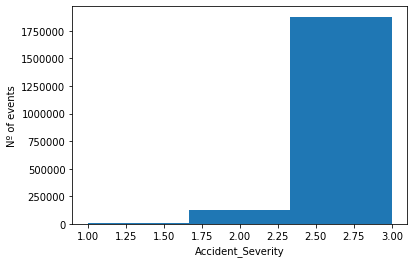

In [17]:
# We verify the distribution we have for Accident_Severity
print(df_cars['Accident_Severity'].value_counts())

plt.hist(df_cars['Accident_Severity'], bins = 3, align='mid')
plt.xlabel('Accident_Severity')
plt.ylabel('Nº of events')

#### 2.2. Sex of Driver

In [25]:
# Removing data values in this column that are set as not specified = 3
df_cars.drop(df_cars.loc[df_cars['Sex_of_Driver']==3].index, inplace=True)
print(df_cars.shape)

(1918837, 9)


In [27]:
df_cars['Sex_of_Driver'].value_counts()

1.0    1154161
2.0     764676
Name: Sex_of_Driver, dtype: int64

In [28]:
df_cars.groupby(['Accident_Severity','Sex_of_Driver']).size()

Accident_Severity  Sex_of_Driver
1                  1.0                 6610
                   2.0                 1899
2                  1.0                80326
                   2.0                39540
3                  1.0              1067225
                   2.0               723237
dtype: int64

#### 2.3. Light Conditions

Accident_Severity  Light_Conditions
1                  0                      3655
                   1                      4854
2                  0                     37481
                   1                     82385
3                  0                    441581
                   1                   1348881
dtype: int64


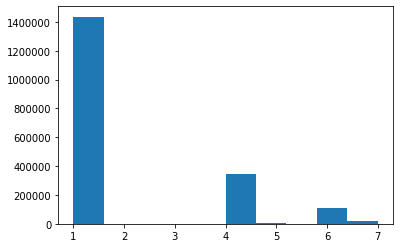

In [29]:
plt.hist(df_cars['Light_Conditions'])

# if 0 there is some kind of darkness situation, if 1 daylight
df_cars['Light_Conditions'].replace({1:1 , 4:0 , 5:0, 6:0, 7:0}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Light_Conditions']).size())

#### 2.4. Road Surface Conditions

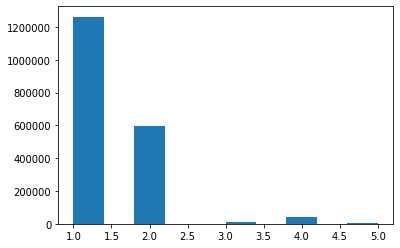

In [30]:
plt.hist(df_cars['Road_Surface_Conditions'])

# We set new categories (simplified) => 1 = dry , 2 = wet / ice / snow related
df_cars['Road_Surface_Conditions'].replace({1:1 , 2:2 , 3:2, 4:2, 5:2}, inplace=True)

In [31]:
print(df_cars.groupby(['Accident_Severity','Road_Surface_Conditions']).size())

Accident_Severity  Road_Surface_Conditions
1                  1.0                           5520
                   2.0                           2989
2                  1.0                          80476
                   2.0                          39390
3                  1.0                        1176330
                   2.0                         614132
dtype: int64


#### 2.5. Urban or rural area

In [32]:
df_cars['Urban_or_Rural_Area'].value_counts()

1    1106533
2     812153
3        151
Name: Urban_or_Rural_Area, dtype: int64

We will group big cities accidents in 0 and the rest small cities and rural in 1

In [33]:
df_cars['Urban_or_Rural_Area'].replace({1:0 , 2:1, 3:1}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Urban_or_Rural_Area']).size())

Accident_Severity  Urban_or_Rural_Area
1                  0                         2169
                   1                         6340
2                  0                        57591
                   1                        62275
3                  0                      1046773
                   1                       743689
dtype: int64


#### 2.6. First point of impact

1.0    954553
2.0    442917
3.0    269099
4.0    193283
0.0     58985
Name: 1st_Point_of_Impact, dtype: int64
(1859852, 9)


,Sex_of_Driver,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,1st_Point_of_Impact,Speed_limit,Date,Day_of_Week,Accident_Severity
0,1.0,0,1.0,0,1.0,30,06/01/2005,5,3
2,1.0,0,1.0,0,1.0,30,13/01/2005,5,3
3,1.0,0,1.0,0,1.0,30,15/01/2005,7,3
4,1.0,0,1.0,0,1.0,30,15/01/2005,7,3
5,2.0,0,1.0,0,1.0,30,15/01/2005,7,3


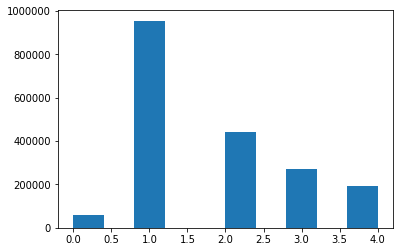

In [34]:
plt.hist(df_cars['1st_Point_of_Impact'])

print(df_cars['1st_Point_of_Impact'].value_counts())

df_cars['1st_Point_of_Impact'].replace({0:0, 1:1 , 2:1, 3:1, 4:1}, inplace=True)

# If we take cases where there is an impact
df_cars = df_cars.loc[df_cars['1st_Point_of_Impact'] == 1]
print(df_cars.shape)
df_cars.head()

In [35]:
df_cars.drop(columns = '1st_Point_of_Impact', inplace = True)

In [36]:
df_cars.shape

(1859852, 8)

#### 2.7. Speed limit

In [37]:
print(df_cars.groupby(['Accident_Severity','Speed_limit']).size())

df_cars['Speed_limit'].replace({10:0, 15:0 , 20:0, 30:0, 40:1, 50:1, 60:1, 70:1}, inplace=True)

print(df_cars.groupby(['Accident_Severity','Speed_limit']).size())

Accident_Severity  Speed_limit
1                  20                 26
                   30               1927
                   40                682
                   50                433
                   60               3515
                   70               1161
2                  10                  1
                   20                710
                   30              55044
                   40              10351
                   50               5063
                   60              33110
                   70               9376
3                  10                  1
                   15                  5
                   20              10336
                   30             981403
                   40             178950
                   50              75660
                   60             304114
                   70             187984
dtype: int64
Accident_Severity  Speed_limit
1                  0                1953
                   1   

#### 2.8. Date: month and day of the week

In [38]:
# Date is object, we make it datetime object in order to later extract month
df_cars['Date']= pd.to_datetime(df_cars['Date'])

# Extracting month from Date
df_cars['Month'] = df_cars['Date'].dt.month

# Droping Date now
df_cars.drop(columns = ['Date'], inplace=True)

In [39]:
df_cars['Month'].value_counts()

11    168122
10    163524
1     161474
7     158032
5     157763
9     157262
6     155218
8     154651
4     149259
3     149231
12    147729
2     137587
Name: Month, dtype: int64

In [40]:
df_cars.groupby(['Accident_Severity','Month']).size()

Accident_Severity  Month
1                  1           665
                   2           614
                   3           610
                   4           620
                   5           669
                   6           603
                   7           690
                   8           632
                   9           675
                   10          693
                   11          659
                   12          614
2                  1          9487
                   2          8197
                   3          9065
                   4          9076
                   5          9662
                   6          9943
                   7          9857
                   8          9636
                   9          9972
                   10        10085
                   11         9966
                   12         8709
3                  1        151322
                   2        128776
                   3        139556
                   4        13

In [41]:
df_cars['Month'].replace({1:1 , 2:1 , 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}, inplace=True)

In [42]:
df_cars['Day_of_Week'].value_counts()

6    310414
4    285891
5    282194
3    282143
2    267335
7    236457
1    195418
Name: Day_of_Week, dtype: int64

In [43]:
df_cars.groupby(['Accident_Severity','Day_of_Week']).size()

Accident_Severity  Day_of_Week
1                  1                1374
                   2                 958
                   3                 894
                   4                 959
                   5                 975
                   6                1193
                   7                1391
2                  1               14911
                   2               15565
                   3               16384
                   4               16136
                   5               16745
                   6               17727
                   7               16187
3                  1              179133
                   2              250812
                   3              264865
                   4              268796
                   5              264474
                   6              291494
                   7              218879
dtype: int64

In [44]:
df_cars['Day_of_Week'].replace({1:0 , 2:1 , 3:1, 4:1, 5:1, 6:0, 7:0}, inplace=True)

We replace data type as needed

In [45]:
# We see the types of data we have and later replace data type accordingly if needed
print(df_cars.dtypes)

Sex_of_Driver              float64
Light_Conditions             int64
Road_Surface_Conditions    float64
Urban_or_Rural_Area          int64
Speed_limit                  int64
Day_of_Week                  int64
Accident_Severity            int64
Month                        int64
dtype: object


In [46]:
# Arranging the order of the columns in the df_cars so that is easier to understand
df_cars = df_cars[['Sex_of_Driver',
                   'Light_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area',
                   'Speed_limit',
                   'Day_of_Week',
                   'Accident_Severity']]

In [47]:
# We check now correlation values with Accident_Severity
print(df_cars['Accident_Severity'].value_counts())
df_cars.corr()

3    1738453
2     113655
1       7744
Name: Accident_Severity, dtype: int64


,Sex_of_Driver,Light_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Speed_limit,Day_of_Week,Accident_Severity
Sex_of_Driver,1.000000,0.082586,0.003862,-0.006513,-0.015494,0.043430,0.042699
Light_Conditions,0.082586,1.000000,-0.185675,0.018758,0.000178,0.038032,0.045380
Road_Surface_Conditions,0.003862,-0.185675,1.000000,0.103964,0.100384,0.015135,0.004397
Urban_or_Rural_Area,-0.006513,0.018758,0.103964,1.000000,0.639037,-0.004701,-0.065206
Speed_limit,-0.015494,0.000178,0.100384,0.639037,1.000000,0.001049,-0.053038
Day_of_Week,0.043430,0.038032,0.015135,-0.004701,0.001049,1.000000,0.021133
Accident_Severity,0.042699,0.045380,0.004397,-0.065206,-0.053038,0.021133,1.000000


In [48]:
# We save the final dataset for Modeling
df_cars.to_csv('carsForModeling.csv',index=False)

### 3. Modeling

### 3.1. Logistic regression

Loading data for modeling:

In [49]:
pd.read_csv('carsForModeling.csv');

We binarize Accident_Severity, Fatal = 1 and Severe/Slight = 0

In [50]:
df_cars['Accident_Severity'].replace({1:1 , 2:0 , 3:0}, inplace=True)

In [51]:
aa,bb = df_cars['Accident_Severity'].value_counts()
print(aa)
print(bb)

1852108
7744


We apply a logistic regression taking a homogeneous random sub-dataset from the total dataset we have, meaning same nº of events 'fatal' and events 'Severe/Slight'.

As metrics we will use:
1. F1_score (average for binary case)
2. Accuracy
3. Cross_validation_score
4. ROC AUC, that will allow to understand for different thresholding values how the model is behaving in general

Note that, in general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

Precision:  0.6233404263996005
Recall:  0.67516218721038
F1_score 0.6979825353809094
logisticRegression Accuracy:  0.6762427372498386
crossValidationScore:  [0.67790045 0.67925625 0.67764432]


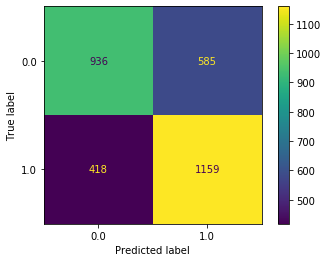

ROC AUC:  0.7277168468329875


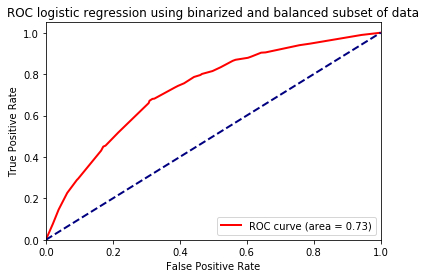

0.6153846153846154
0.7349397590361446


In [52]:
# We prepare the sub-dataset
a = df_cars.loc[df_cars['Accident_Severity'] == 0]
b = df_cars.loc[df_cars['Accident_Severity'] == 1]

# We see that the limitant is the number of events with have as 'fatal' n=7744. We therefore consider 7700 events as 'fatal' and
# 7700 as 'Severe/Slight'
a = a.sample(n = bb)
b = b.sample(n = bb)
new_cars = np.concatenate([a,b],axis=0)
n,m = new_cars.shape
X = new_cars[:,1:m-1]
y = new_cars[:,m-1]

# We normalize X
X = StandardScaler().fit(X).transform(X)

# We split the sub-dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

# We train the logistic regression model
clf = LogisticRegression(solver='lbfgs',max_iter=3000).fit(X, y)

# We extract the predictions using X_test
y_hat = clf.predict(X_test)

# We now measure the model
print("Precision: ", average_precision_score(y_test, y_hat, average='macro'))
print("Recall: ", recall_score(y_test, y_hat, average='macro'))
print("F1_score", f1_score(y_test,y_hat,average='binary'))
print("logisticRegression Accuracy: ", accuracy_score(y_test, y_hat))
print("crossValidationScore: ", cross_val_score(clf, X, y, cv=3))

# Confusion matrix visualuzation
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# We will now calculate the ROC AUC and plot it
# Learn to predict each class against the other
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve, ROC area and plot it
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('ROC AUC: ', roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC logistic regression using binarized and balanced subset of data')
plt.legend(loc="lower right")
plt.show()

cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)

### 3.2. Decision tree

DecisionTrees's f1_score:  0.674556485081759
DecisionTrees's Accuracy:  0.6762427372498386


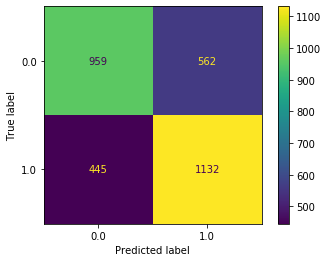

0.6153846153846154
0.7349397590361446


In [62]:
# Decision tree
DT = tree.DecisionTreeClassifier(criterion="entropy",max_depth=4)
DT = DT.fit(X_train,y_train)
print("DecisionTrees's f1_score: ", f1_score(y_test,y_hat, average = 'macro'))
print("DecisionTrees's Accuracy: ", accuracy_score(y_test, y_hat))
cm = confusion_matrix(y_test, y_hat)
plot_confusion_matrix(DT, X_test, y_test)
plt.show()
cmfor0 = cm[0,0]/np.sum(cm[0,]); print(cmfor0)
cmfor1 = cm[1,1]/np.sum(cm[1,]); print(cmfor1)

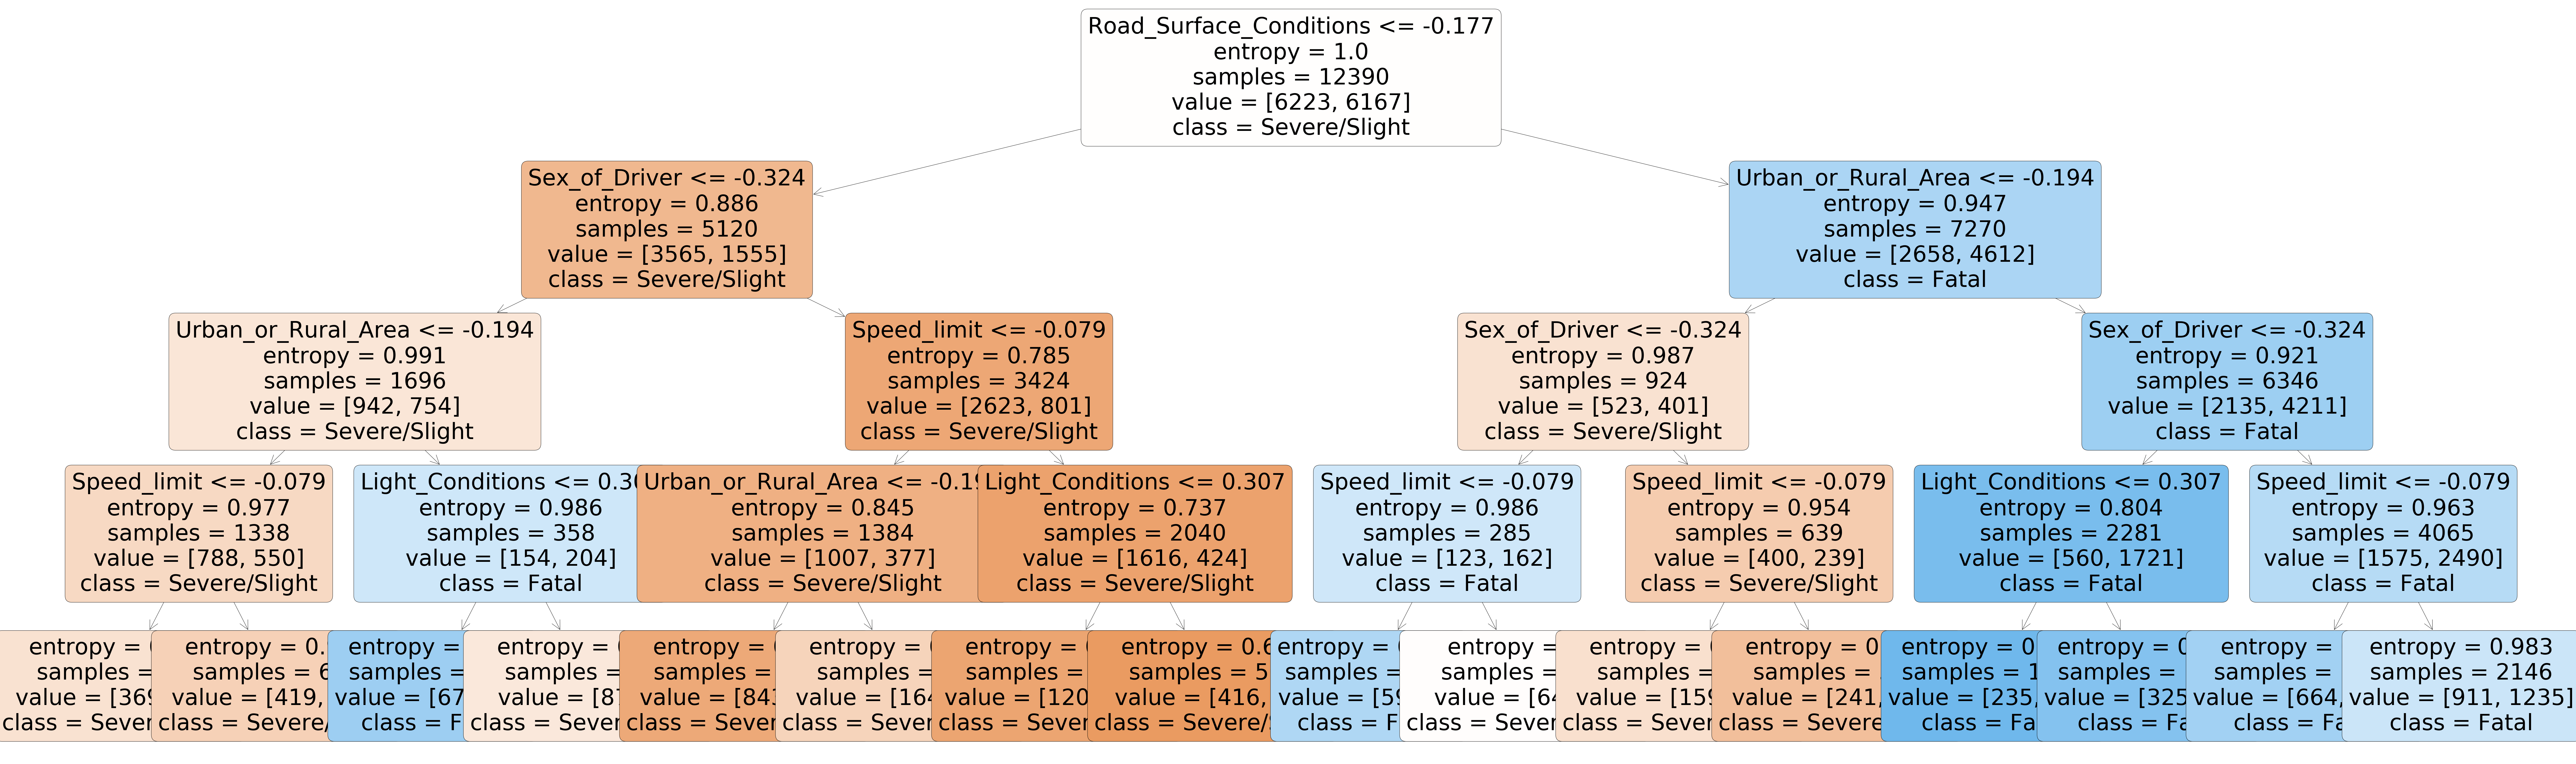

In [65]:
plt.figure(figsize=(160,50))
a = plot_tree(DT,
              class_names=["Severe/Slight","Fatal"],
              feature_names=['Sex_of_Driver','Light_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area','Speed_limit','Day_of_Week'],
              filled=True, 
              rounded=True, 
              fontsize=80)